## <center> RNN Exercise </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("C:/Users/Lenovo/Desktop/Python/Deep Learning/Data Sets/TensorFlow/Frozen_Dessert_Production.csv", index_col="DATE", parse_dates=True)
df.columns = ["Production"]
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


**TASK: Plot out the time series**

<AxesSubplot:xlabel='DATE'>

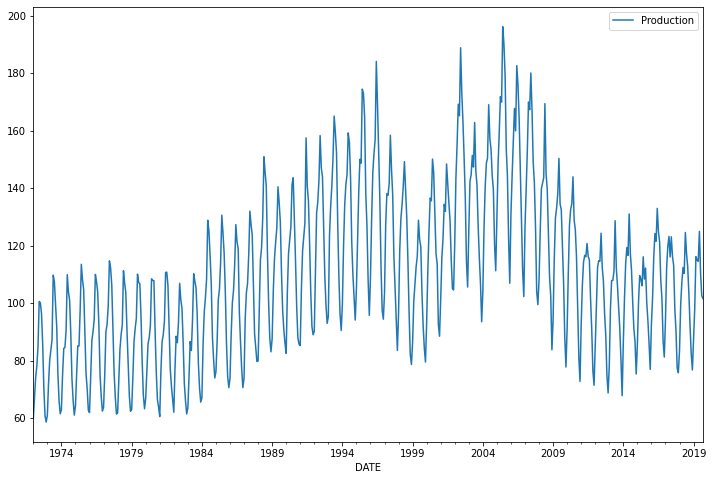

In [3]:
df.plot(figsize=(12,8))

**TASK: Figure out the length of the data set**

In [4]:
len(df)

573

**TASK: Split the data into a train/test split where the test set is the last 24 months of data.**

In [5]:
test_ind = 24

train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [6]:
scaler = MinMaxScaler()

train_s = scaler.fit_transform(train)
test_s = scaler.transform(test)

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The batch length is up to you, but at a minimum it should be at least 18 to capture a full year seasonality.**

In [7]:
length = 18

train_generator = TimeseriesGenerator(
    data= train_s,
    targets= train_s,
    length= length,
    batch_size= 1,
)

**TASK: Create a Keras Sequential Model with as many LSTM units you want and a final Dense Layer.**

In [8]:
model = Sequential()

model.add(LSTM(100, input_shape=(length, 1), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(25))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 18, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 78,626
Trainable params: 78,626
Non-trainable params: 0
_________________________________________________________________


**TASK: Create a generator for the scaled test/validation set. NOTE: Double check that your batch length makes sense for the size of the test set as mentioned in the RNN Time Series video.**

In [10]:
test_generator = TimeseriesGenerator(
    data= test_s,
    targets= test_s,
    length= length,
    batch_size= 1,
)

**TASK: Create an EarlyStopping callback based on val_loss.**

In [11]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

**TASK: Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [12]:
model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stop]
)

Epoch 1/100
531/531 [==============================] - 11s 13ms/step - loss: 0.0261 - val_loss: 0.0036
Epoch 2/100
531/531 [==============================] - 6s 12ms/step - loss: 0.0093 - val_loss: 0.0011
Epoch 3/100
531/531 [==============================] - 6s 11ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 4/100
531/531 [==============================] - 6s 11ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 5/100
531/531 [==============================] - 6s 11ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 6/100
531/531 [==============================] - 6s 11ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 7/100
531/531 [==============================] - 6s 11ms/step - loss: 0.0043 - val_loss: 0.0034


**TASK: Plot the history of the loss that occured during training.**

<AxesSubplot:>

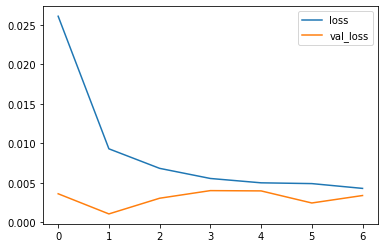

In [13]:
losses = pd.DataFrame(model.history.history)
losses.plot()

**TASK: Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [14]:
test_predictions = []

feb = train_s[-length:]
cb = feb.reshape((1, length, 1))

for i in range(len(test)):
    
    current_pred = model.predict(cb)[0]
    test_predictions.append(current_pred) 
    cb = np.append(cb[:,1:,:],[[current_pred]],axis=1)


true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.head()

1/1 [==============================] - 0s 17ms/step


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15252\1557417679.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,Production,Predictions
DATE,,
2017-10-01,90.4732,92.878796
2017-11-01,77.4378,89.468101
2017-12-01,75.8118,92.740794
2018-01-01,83.4343,104.445188
2018-02-01,99.4899,115.095288


**TASK: Plot your predictions versus the True test values. (Your plot may look different than ours).**

<AxesSubplot:xlabel='DATE'>

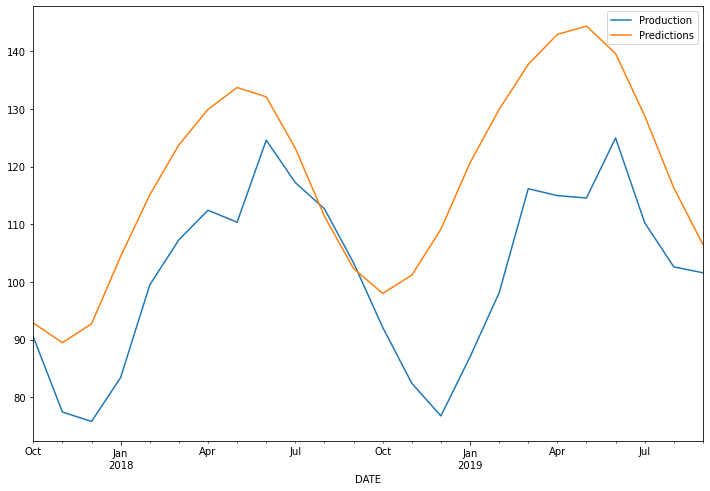

In [15]:
test.plot(figsize=(12,8))

**TASK: Calculate your RMSE.**

In [16]:
RMSE = np.sqrt(mean_squared_error(test["Production"], test["Predictions"]))
RMSE

19.171434932754842

**TASK: Retrain and Forecast for another 2 years**

In [17]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

In [18]:
length = 18

generator = TimeseriesGenerator(
    data= data,
    targets= data,
    length= length,
    batch_size= 1,
)

In [19]:
model.fit(
    generator,
    epochs=10
)

Epoch 1/10
555/555 [==============================] - 6s 11ms/step - loss: 0.0042
Epoch 2/10
555/555 [==============================] - 6s 11ms/step - loss: 0.0035
Epoch 3/10
555/555 [==============================] - 6s 11ms/step - loss: 0.0033
Epoch 4/10
555/555 [==============================] - 6s 11ms/step - loss: 0.0031
Epoch 5/10
555/555 [==============================] - 6s 12ms/step - loss: 0.0030
Epoch 6/10
555/555 [==============================] - 6s 12ms/step - loss: 0.0033
Epoch 7/10
555/555 [==============================] - 6s 11ms/step - loss: 0.0033
Epoch 8/10
555/555 [==============================] - 7s 12ms/step - loss: 0.0027
Epoch 9/10
555/555 [==============================] - 6s 11ms/step - loss: 0.0024
Epoch 10/10
555/555 [==============================] - 6s 12ms/step - loss: 0.0028


In [20]:
forecast = []
periods = 3*12

first_eval_batch = data[-length:]
current_batch = first_eval_batch.reshape((1, length, 1))

for i in range(periods):
    
    current_pred = model.predict(current_batch)[0]  
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


true_predictions = scaler.inverse_transform(forecast)

1/1 [==============================] - 0s 17ms/step


In [21]:
forecast_index = pd.date_range(start=df.index[-1],periods=periods,freq='MS')

In [22]:
forecast_df = pd.DataFrame(data=true_predictions,index=forecast_index,
                           columns=['Forecast'])

<AxesSubplot:>

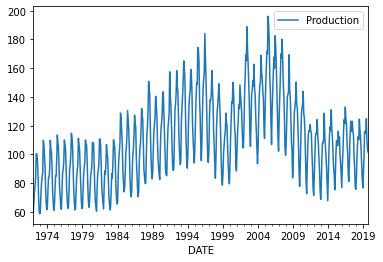

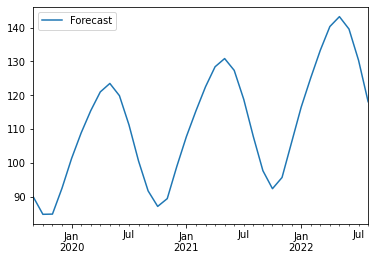

In [23]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

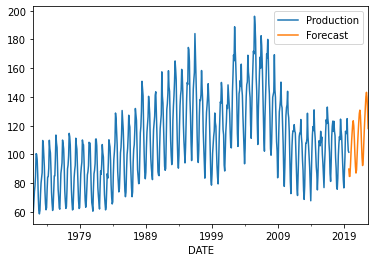

In [25]:
ax = df.plot()
forecast_df.plot(ax=ax)

(469.0, 631.0)

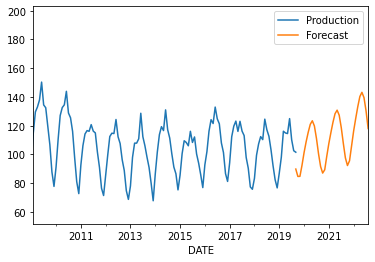

In [26]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2009-02-01',forecast_index[-1])